In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import json
import plotly.io as pio
from scipy.stats import pearsonr

In [2]:
# load U.S. State GeoJSON data
geojson_file_path = 'data/US_State_Boundaries.geojson'

with open(geojson_file_path, 'r') as geojson_file:
    geojson_data = json.load(geojson_file)

In [347]:
# load election results by state csv file using relative path
df_state = pd.read_csv('data/1976-2020-president.csv')
df_state.drop(['state_fips','state_cen', 'office', 
               'writein','version','party_detailed','candidate',
               'notes','state_ic'],axis = 'columns',inplace = True)

In [348]:
df_state.dtypes

year                 int64
state               object
state_po            object
candidatevotes       int64
totalvotes           int64
party_simplified    object
dtype: object

In [349]:
df_state

,year,state,state_po,candidatevotes,totalvotes,party_simplified
0,1976,ALABAMA,AL,659170,1182850,DEMOCRAT
1,1976,ALABAMA,AL,504070,1182850,REPUBLICAN
2,1976,ALABAMA,AL,9198,1182850,OTHER
3,1976,ALABAMA,AL,6669,1182850,OTHER
4,1976,ALABAMA,AL,1954,1182850,OTHER
...,...,...,...,...,...,...
4282,2020,WYOMING,WY,5768,278503,LIBERTARIAN
4283,2020,WYOMING,WY,2208,278503,OTHER
4284,2020,WYOMING,WY,1739,278503,OTHER
4285,2020,WYOMING,WY,279,278503,OTHER


In [350]:
df_state = df_state.groupby(['year','state','state_po',
                            'party_simplified']).agg({'candidatevotes':'sum',
                                                      'totalvotes':'mean'})

df_state.reset_index(drop=False, inplace=True)
#df_state[df_state['state']=='WISCONSIN']

In [351]:
# find winner per year per state
group_state = df_state.groupby(['year','state'])
df_state['rank_'] = group_state['candidatevotes'].rank("dense", ascending=False)
df_state['unique_id'] = df_state['year'].astype(str) + df_state['state_po']
df_state

,year,state,state_po,party_simplified,candidatevotes,totalvotes,rank_,unique_id
0,1976,ALABAMA,AL,DEMOCRAT,659170,1182850.0,1.0,1976AL
1,1976,ALABAMA,AL,LIBERTARIAN,1481,1182850.0,4.0,1976AL
2,1976,ALABAMA,AL,OTHER,18129,1182850.0,3.0,1976AL
3,1976,ALABAMA,AL,REPUBLICAN,504070,1182850.0,2.0,1976AL
4,1976,ALASKA,AK,DEMOCRAT,44058,123574.0,2.0,1976AK
...,...,...,...,...,...,...,...,...
2349,2020,WISCONSIN,WI,REPUBLICAN,1610184,3298041.0,2.0,2020WI
2350,2020,WYOMING,WY,DEMOCRAT,73491,278503.0,2.0,2020WY
2351,2020,WYOMING,WY,LIBERTARIAN,5768,278503.0,3.0,2020WY
2352,2020,WYOMING,WY,OTHER,5685,278503.0,4.0,2020WY


Below section focused on calculating the votes difference in percentage between the Republican party and the Democratic party in each election and creating visuazations to show the trend in each state.

In [352]:
democrat = df_state.query("party_simplified=='DEMOCRAT'")
republican = df_state.query("party_simplified=='REPUBLICAN'")
df_diff = republican.merge(democrat, on = 'unique_id')
#df_diff.rank__x.value_counts()

In [353]:
# calculate vote count difference % for each year between two parties
df_diff.drop(['year_y','state_y','state_po_y','party_simplified_x',
              'party_simplified_y','totalvotes_x',
              'rank__x','rank__y'], axis = 1, inplace = True)


df_diff.rename(columns = {'year_x':'Year', 'state_x':'State','state_po_x':'state_po',
                          'candidatevotes_y':"Dem_votes",'candidatevotes_x':"Rep_votes",
                          'totalvotes_y':'Total_votes'}, inplace = True)



In [354]:
df_diff['Rep_Dem'] = (df_diff['Rep_votes'] - df_diff['Dem_votes']) / df_diff['Total_votes'] *100
df_diff['Rep_Dem_abs'] = abs(df_diff['Rep_Dem'])

In [355]:
# find state with smallest diff per year
group_df_diff = df_diff.groupby(['Year'])
df_diff['rank_'] = group_df_diff['Rep_Dem_abs'].rank("dense", ascending=True)
#df_diff['state'] = df_state['state'].str.title()

In [356]:
df_diff.sort_values(by=['Year','Rep_Dem'])

,Year,State,state_po,Rep_votes,unique_id,Dem_votes,Total_votes,Rep_Dem,Rep_Dem_abs,rank_
8,1976,DISTRICT OF COLUMBIA,DC,27873,1976DC,137818,168830.0,-65.121720,65.121720,51.0
10,1976,GEORGIA,GA,483743,1976GA,979409,1463152.0,-33.876590,33.876590,50.0
3,1976,ARKANSAS,AR,267903,1976AR,498604,767535.0,-30.057392,30.057392,49.0
48,1976,WEST VIRGINIA,WV,314726,1976WV,435864,750590.0,-16.139037,16.139037,42.0
21,1976,MASSACHUSETTS,MA,1030276,1976MA,1429475,2547558.0,-15.669869,15.669869,41.0
...,...,...,...,...,...,...,...,...,...,...
573,2020,IDAHO,ID,554119,2020ID,287021,868014.0,30.771163,30.771163,43.0
597,2020,OKLAHOMA,OK,1020280,2020OK,503890,1560699.0,33.087098,33.087098,44.0
595,2020,NORTH DAKOTA,ND,235595,2020ND,114902,361819.0,33.357286,33.357286,47.0
609,2020,WEST VIRGINIA,WV,545382,2020WV,235984,794652.0,38.935031,38.935031,49.0


In [416]:
df_dem = df_diff[(df_diff['State'].isin(['CALIFORNIA', 'DELAWARE','DISTRICT OF COLUMBIA',
                                        'HAWAII', 'ILLINOIS','NEW YORK',
                                        'RHODE ISLAND','VERMONT']))
            & (df_diff['Year'] > 1996) ]

In [412]:
df_dem

,Year,State,state_po,Rep_votes,unique_id,Dem_votes,Total_votes,Rep_Dem,Rep_Dem_abs,rank_
310,2000,CALIFORNIA,CA,4567429,2000CA,5861203,10965822.0,-11.798240,11.798240,24.0
313,2000,DELAWARE,DE,137288,2000DE,180068,327529.0,-13.061439,13.061439,27.0
314,2000,DISTRICT OF COLUMBIA,DC,18073,2000DC,171923,201894.0,-76.203354,76.203354,51.0
317,2000,HAWAII,HI,137845,2000HI,205286,367951.0,-18.328799,18.328799,36.0
338,2000,NEW YORK,NY,2258577,2000NY,3942215,6960215.0,-24.189454,24.189454,41.0
345,2000,RHODE ISLAND,RI,130555,2000RI,249508,409112.0,-29.075901,29.075901,46.0
351,2000,VERMONT,VT,119775,2000VT,149022,294308.0,-9.937548,9.937548,22.0
361,2004,CALIFORNIA,CA,5509826,2004CA,6745485,12421353.0,-9.947862,9.947862,21.0
364,2004,DELAWARE,DE,171660,2004DE,200152,375190.0,-7.594019,7.594019,16.0
365,2004,DISTRICT OF COLUMBIA,DC,21256,2004DC,202970,227586.0,-79.844103,79.844103,51.0


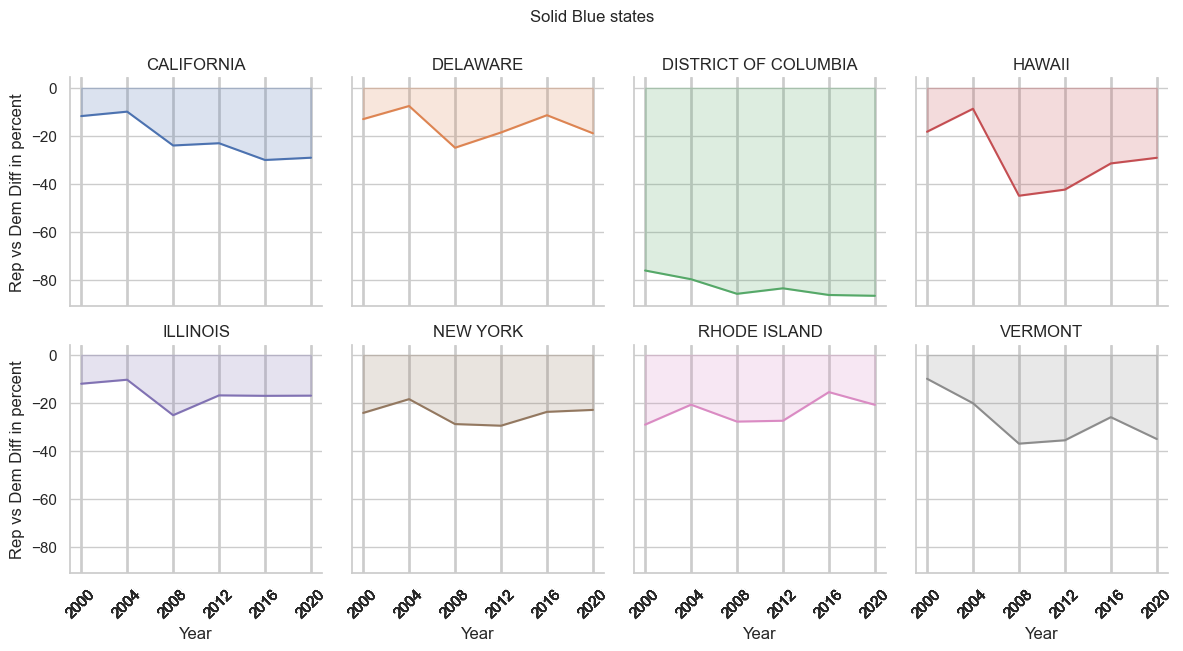

In [418]:
# Create a grid : initialize it
g = sns.FacetGrid(df_dem, col='State', hue='State', col_wrap=4)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Solid Blue states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_dem['Year'])
g.set_xticklabels(df_dem['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('Solid_Blue_area_chart.png')

# Show the graph
plt.show()

In [435]:
df_rep = df_diff[(df_diff['State'].isin(['ALASKA', 'NEBRASKA',
                                        'NORTH DAKOTA', 'SOUTH DAKOTA','WYOMING']))
            & (df_diff['Year'] > 1996) ]

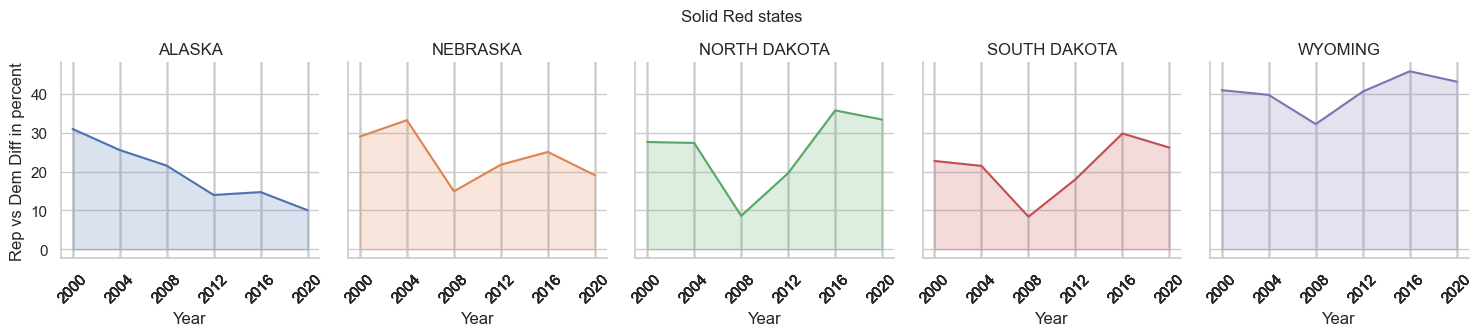

In [438]:
# Create a grid : initialize it
g = sns.FacetGrid(df_rep, col='State', hue='State', col_wrap=5)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Solid Red states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_rep['Year'])
g.set_xticklabels(df_rep['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('Solid_Red_area_chart.png')

# Show the graph
plt.show()

In [439]:
df_focus1 = df_diff[(df_diff['State'].isin(['ARIZONA', 'GEORGIA','NORTH CAROLINA','TEXAS',]))
            & (df_diff['Year'] > 1996) ]

In [440]:
df_focus2 = df_diff[(df_diff['State'].isin(['FLORIDA','MICHIGAN','NEVADA',
                                             'PENNSYLVANIA','WISCONSIN']))
            & (df_diff['Year'] > 1996) ]

In [441]:
df_focus3 = df_diff[(df_diff['State'].isin(['INDIANA','IOWA','MINNESOTA',
                                            'NEW HAMPSHIRE','OHIO']))
            & (df_diff['Year'] > 1996) ]

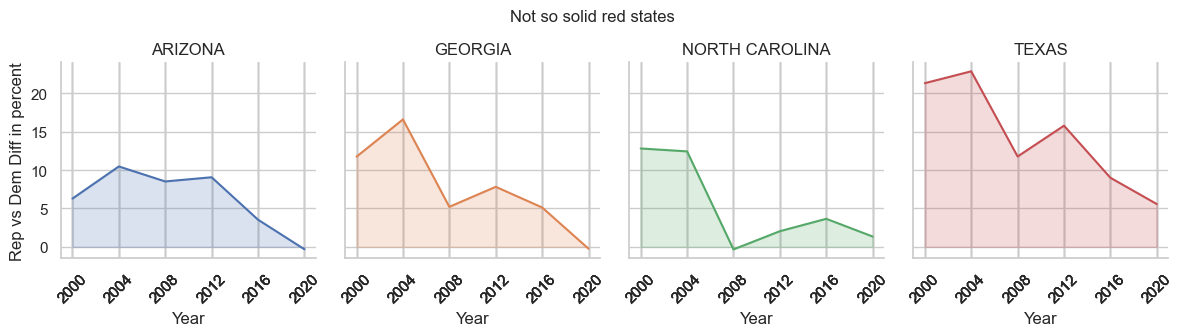

In [443]:
# Create a grid : initialize it
g = sns.FacetGrid(df_focus1, col='State', hue='State', col_wrap=4)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Not so solid red states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_focus1['Year'])
g.set_xticklabels(df_focus1['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('focus1_area_chart.png')

# Show the graph
plt.show()

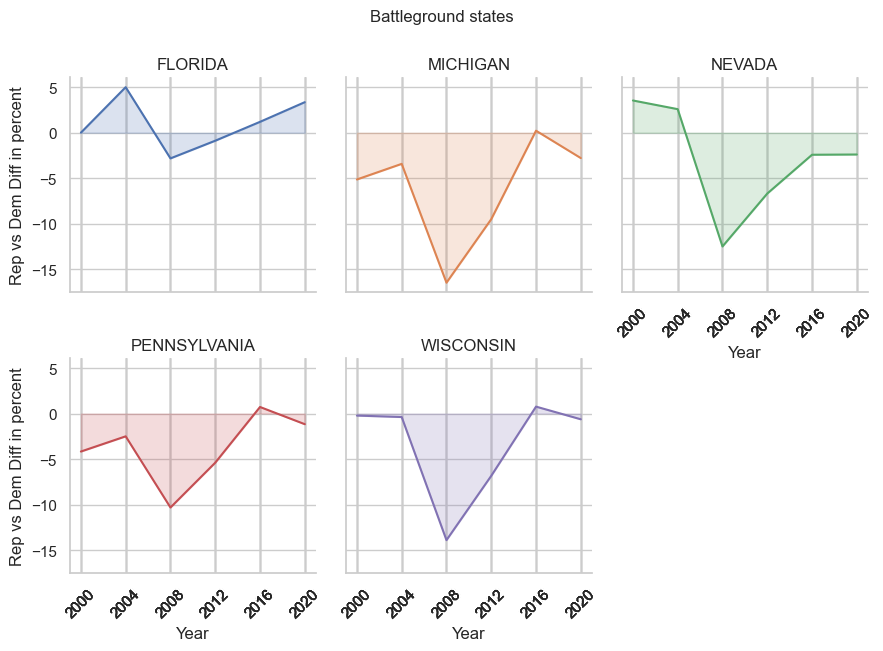

In [445]:
# Create a grid : initialize it
g = sns.FacetGrid(df_focus2, col='State', hue='State', col_wrap=3)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Battleground states', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_focus2['Year'])
g.set_xticklabels(df_focus2['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('focus2_area_chart.png')

# Show the graph
plt.show()

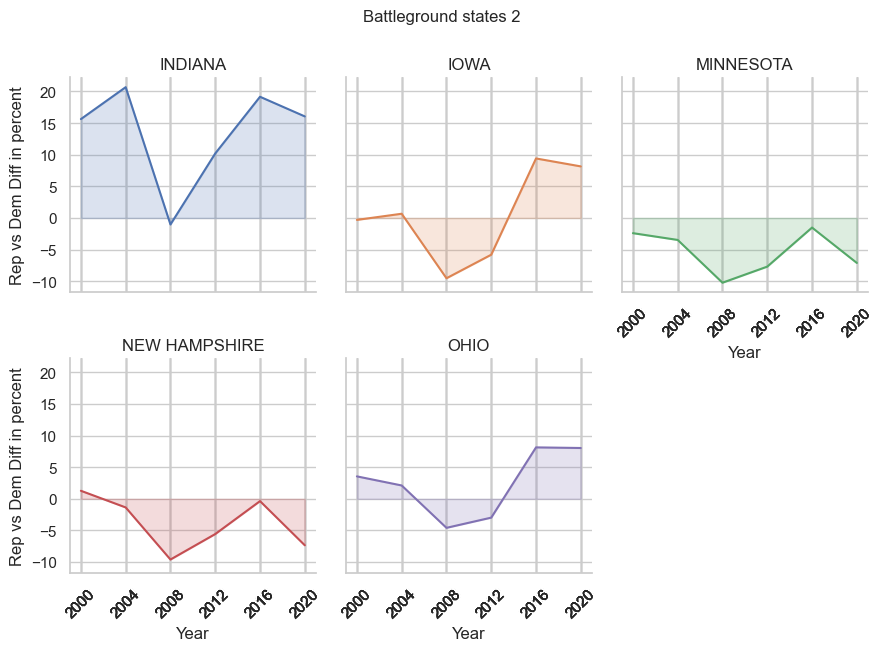

In [446]:
# Create a grid : initialize it
g = sns.FacetGrid(df_focus3, col='State', hue='State', col_wrap=3)

# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'Rep_Dem')
 
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'Rep_Dem', alpha=0.2).set_titles("{col_name} State")
 
# Control the title of each facet
g = g.set_titles("{col_name}")
 
# Add a title for the whole plot
#plt.subplots_adjust(top=0.9)
#g = g.fig.suptitle('Change of popular votes % in 3 States')

# Add a title to the entire figure
g.fig.suptitle('Battleground states 2', fontsize=12, x=0.5, y=1.05)

g.set(ylabel='Rep vs Dem Diff in percent')

# Manually set x-axis values and labels
g.set(xticks=df_focus3['Year'])
g.set_xticklabels(df_focus3['Year'], rotation=45)

# Remove grid lines in each subplot
for ax in g.axes.flat:
    ax.grid(True)

plt.savefig('focus3_area_chart.png')

# Show the graph
plt.show()

Below section focused on calculating how many tight races each state had during the past six elections (from 2000 to 2020). Tight race is defined as having the votes difference in percentage between the two parties is less than 5%.

In [358]:
df_battle = df_diff[(df_diff['Rep_Dem_abs'] < 5) & (df_diff['Year'] > 1996)]
#df_battle['State'] = df_battle['State'].str.title()#apply(lambda x: x.title())

In [359]:
df_battle.State.unique()

array(['FLORIDA', 'IOWA', 'MINNESOTA', 'MISSOURI', 'NEVADA',
       'NEW HAMPSHIRE', 'NEW MEXICO', 'OHIO', 'OREGON', 'PENNSYLVANIA',
       'TENNESSEE', 'WISCONSIN', 'COLORADO', 'MICHIGAN', 'INDIANA',
       'MONTANA', 'NORTH CAROLINA', 'VIRGINIA', 'ARIZONA', 'MAINE',
       'GEORGIA'], dtype=object)

In [360]:
df_battle.State.value_counts()

FLORIDA           5
OHIO              4
WISCONSIN         4
PENNSYLVANIA      4
NORTH CAROLINA    4
NEVADA            4
NEW HAMPSHIRE     3
MINNESOTA         3
MICHIGAN          3
NEW MEXICO        2
MISSOURI          2
IOWA              2
COLORADO          2
ARIZONA           2
OREGON            2
VIRGINIA          1
MAINE             1
TENNESSEE         1
MONTANA           1
INDIANA           1
GEORGIA           1
Name: State, dtype: int64

In [324]:
df_battle

,Year,State,state_po,Rep_votes,unique_id,Dem_votes,Total_votes,Rep_Dem,Rep_Dem_abs,rank_,state
315,2000,FLORIDA,FL,2912790,2000FL,2912253,5963110.0,0.009005,0.009005,1.0,Ohio
321,2000,IOWA,IA,634373,2000IA,638517,1353022.0,-0.306277,0.306277,4.0,Oklahoma
329,2000,MINNESOTA,MN,1109659,2000MN,1168266,2438685.0,-2.403221,2.403221,7.0,Pennsylvania
331,2000,MISSOURI,MO,1189924,2000MO,1111138,2359892.0,3.338543,3.338543,8.0,Rhode Island
334,2000,NEVADA,NV,301575,2000NV,279978,609426.0,3.543826,3.543826,9.0,Rhode Island
335,2000,NEW HAMPSHIRE,NH,273559,2000NH,266348,569081.0,1.267131,1.267131,6.0,South Carolina
337,2000,NEW MEXICO,NM,286417,2000NM,286783,598605.0,-0.061142,0.061142,2.0,South Carolina
341,2000,OHIO,OH,2350363,2000OH,2183628,4701998.0,3.546046,3.546046,10.0,South Dakota
343,2000,OREGON,OR,713577,2000OR,720342,1533950.0,-0.441018,0.441018,5.0,Tennessee
344,2000,PENNSYLVANIA,PA,2281127,2000PA,2485967,4912185.0,-4.170038,4.170038,12.0,Tennessee


In [362]:
df_battle_gb = df_battle.groupby('State').size().reset_index(name='num_tight_race')#['state'].count()

In [377]:
df_battle_gb['State'] = df_battle_gb['State'].str.title()
top9_battle = df_battle_gb.sort_values(by='num_tight_race', ascending=False).head(9)

In [378]:
top9_battle

,State,num_tight_race
2,Florida,5
15,Ohio,4
14,North Carolina,4
11,Nevada,4
20,Wisconsin,4
17,Pennsylvania,4
8,Minnesota,3
12,New Hampshire,3
7,Michigan,3


In [381]:
fig_bar_battle = px.bar(top9_battle,
                         x='State',
                         y='num_tight_race',
                         text='num_tight_race')
                    

# Update layout
fig_bar_battle.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='number of tight races',
                                title=dict(text='Top 9 states with most tight races from 2000 to 2020',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
fig_bar_battle.write_image('top_battle_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility

fig_bar_battle.show()

Below section focused on calculating the votes difference in percentage between the Republican party and the Democratic party in each election and plotting the heatmap using these data points.

In [43]:
# create sub-data frame to plot the heat map
df_heatmap = df_diff[['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap = df_heatmap.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

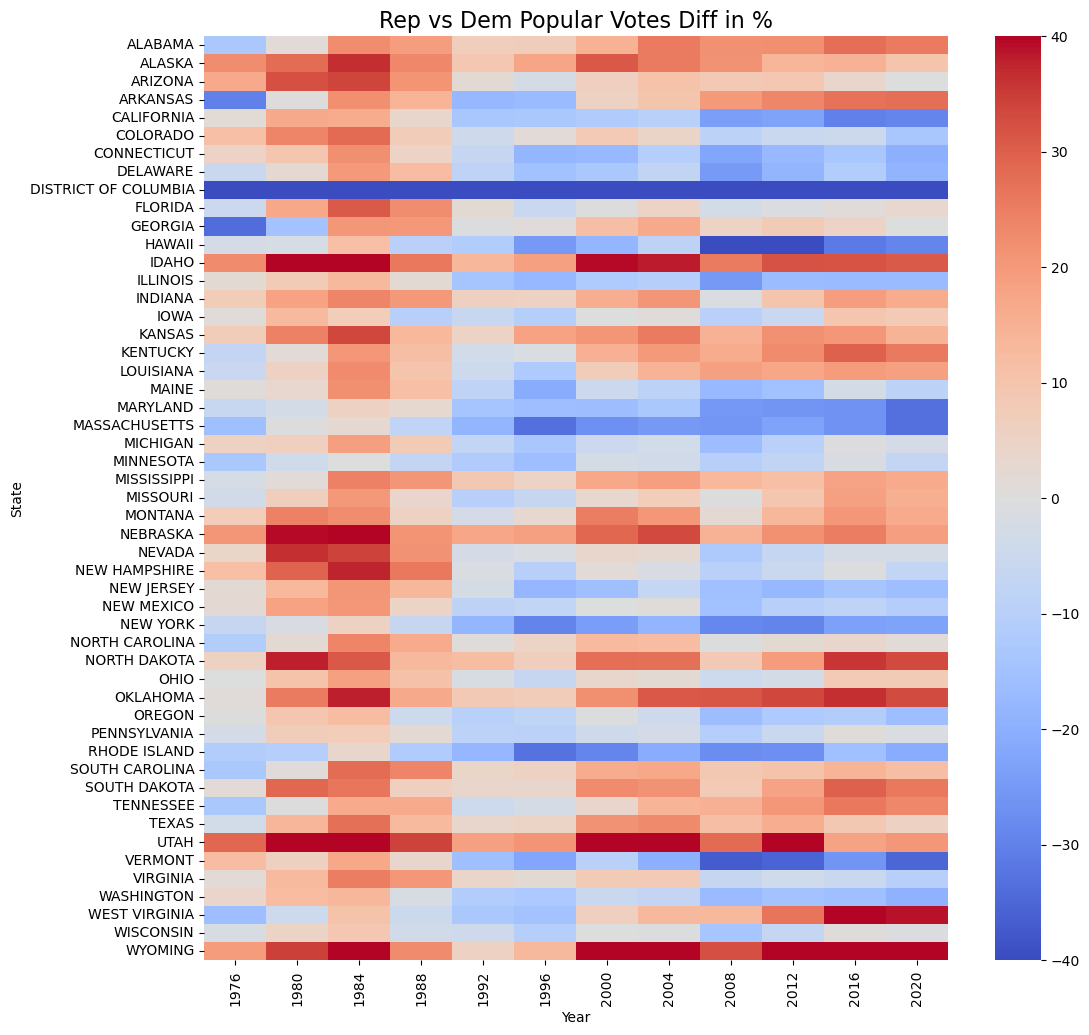

In [44]:
#Plotting the political trend in states
g = sns.heatmap(df_heatmap, vmax = 40, vmin = -40,cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 16, y = 1.0)
g.figure.set_size_inches(12, 12)
fig = g.get_figure()
fig.savefig('State_level_heatmap.jpg')

In [45]:
# create sub-data frame to plot the heat map
df_heatmap_pac = df_diff[df_diff['state_po'].isin(['AK','CA','HI','OR','WA'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_pac = df_heatmap_pac.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

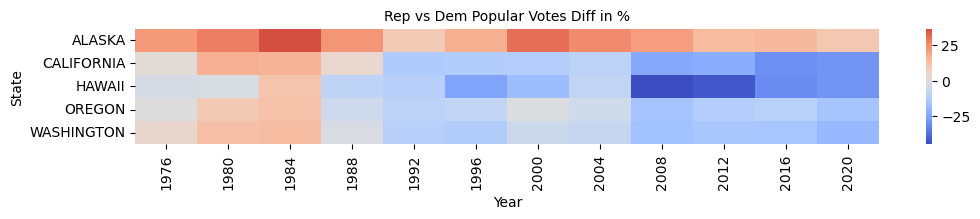

In [47]:
#Plotting the political trend in states
# vmax = 0.4, vmin = -0.4, 
g = sns.heatmap(df_heatmap_pac, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 1.5)
fig = g.get_figure()
fig.savefig('Pacific_heatmap.jpg')


In [48]:
# create sub-data frame to plot the heat map
df_heatmap_ne = df_diff[df_diff['state_po'].isin(['CT','ME','NH','RI','VT','NJ','NY','PA'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_ne = df_heatmap_ne.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

In [318]:
df_heatmap_ne

Year,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020
State,,,,,,,,,,,,
CONNECTICUT,5.147744,9.633751,21.901970,5.103042,-6.435332,-18.140777,-17.466025,-10.366431,-22.367366,-17.339899,-13.639387,-20.073613
MAINE,0.836701,3.355188,22.053028,11.451890,-8.376171,-20.863282,-5.114165,-8.996398,-17.321719,-15.043642,-2.868536,-8.974351
NEW HAMPSHIRE,11.274133,29.386442,37.722163,26.156373,-1.220368,-10.004088,1.267131,-1.367268,-9.605469,-5.575888,-0.367596,-7.351566
NEW JERSEY,2.157426,13.415168,20.892972,13.641967,-2.372926,-17.857185,-15.834365,-6.684597,-15.568203,-17.718790,-14.102698,-15.937673
NEW YORK,-6.272279,-1.461990,5.512626,-6.430672,-18.436564,-29.676731,-24.189454,-18.444051,-28.839724,-29.519387,-23.745540,-22.930591
PENNSYLVANIA,-2.663464,7.110203,7.351891,2.317839,-9.018954,-9.211769,-4.170038,-2.500143,-10.318476,-5.395992,0.724270,-1.164884
RHODE ISLAND,-11.297810,-10.469340,3.647844,-11.705246,-18.020359,-32.893783,-29.075901,-20.751989,-27.806158,-27.457297,-15.508549,-20.805818
VERMONT,12.283173,5.942831,17.110688,3.516241,-15.695493,-22.264354,-9.937548,-20.136147,-37.006454,-35.597915,-25.963360,-35.074723


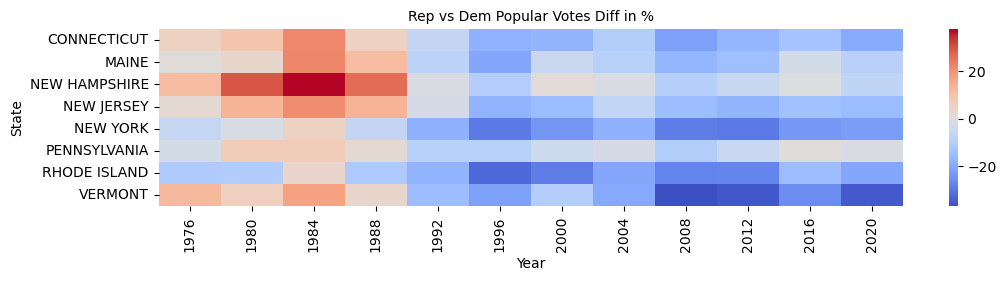

In [49]:
#Plotting the political trend in states
#vmax = 0.4, vmin = -0.4,
g = sns.heatmap(df_heatmap_ne,  cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 2.3)
fig = g.get_figure()
fig.savefig('Northeast_heatmap.jpg')

In [50]:
# create sub-data frame to plot the heat map
df_heatmap_mt = df_diff[df_diff['state_po'].isin(['ID','MT','WY','UT','CO','NM','AZ'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_mt = df_heatmap_mt.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

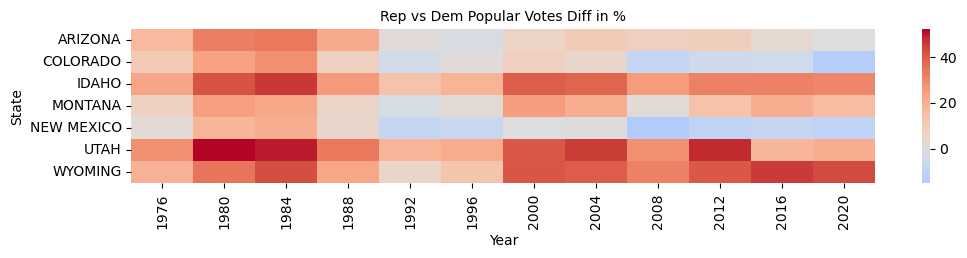

In [51]:
#Plotting the political trend in states
# vmax = 1.0, vmin = -1.0, 
g = sns.heatmap(df_heatmap_mt, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 2)
fig = g.get_figure()
fig.savefig('Mountain_heatmap.jpg')

In [52]:
# create sub-data frame to plot the heat map
df_heatmap_mid_west = df_diff[df_diff['state_po'].isin(['IL','IN','IA','KS',
                                                        'MI','MN','MO','NE',
                                                       'ND','OH','SD','WI'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_mid_west = df_heatmap_mid_west.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

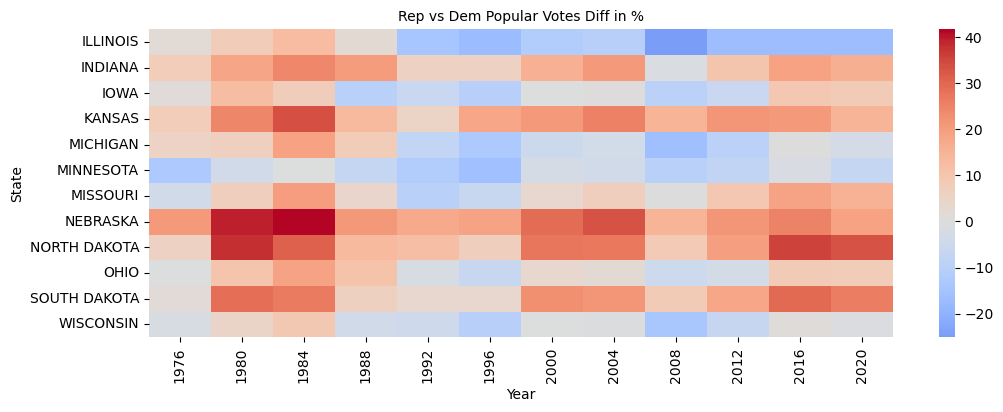

In [53]:
#Plotting the political trend in states
# vmax = 1.0, vmin = -1.0, 
g = sns.heatmap(df_heatmap_mid_west, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 4)
fig = g.get_figure()
fig.savefig('Midwest_heatmap.jpg')

In [54]:
# create sub-data frame to plot the heat map
df_heatmap_south = df_diff[df_diff['state_po'].isin(['AL','AR','DE',#'DC',
                                                     'FL','GA','KY','LA',
                                                     'MS','NC','OK','SC',
                                                    'TN','TX','VA','WV'])][['Year', 'State', 'Rep_Dem']]

# convert to pivot table
df_heatmap_south = df_heatmap_south.pivot(index = 'State', columns = 'Year', values = 'Rep_Dem')

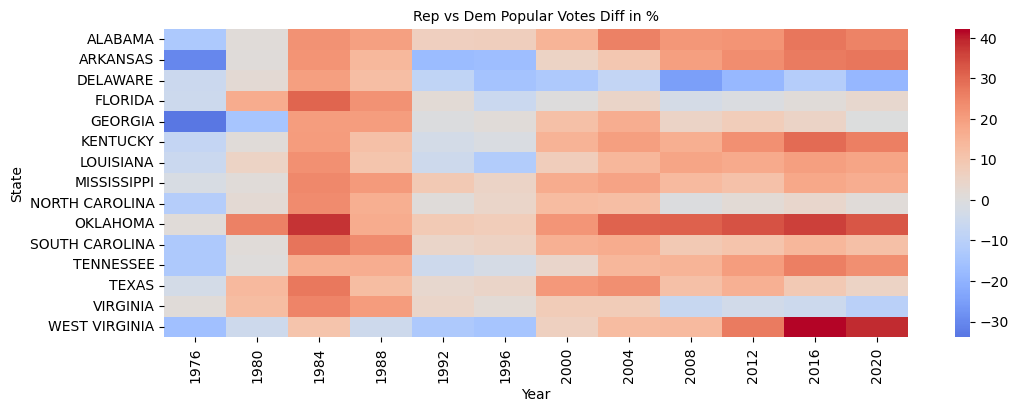

In [55]:
#Plotting the political trend in states
# vmax = 1.0, vmin = -1.0, 
g = sns.heatmap(df_heatmap_south, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('Rep vs Dem Popular Votes Diff in %', size = 10, y = 1)
g.figure.set_size_inches(12, 4)
fig = g.get_figure()
fig.savefig('South_heatmap.jpg')

Below section is dedicated to creating the data frame that calculates the total votes for Republican party and Democratic party in each election and visualizations that are associated with it.

In [56]:
df_national = df_diff.groupby(['Year']).agg({'Rep_votes':'sum',
                                            'Dem_votes':'sum',
                                            'Total_votes':'sum',})
df_national.reset_index(inplace=True)
df_national['Rep_Dem_national'] = round((df_national['Rep_votes'] - df_national['Dem_votes']) /df_national['Total_votes'] *100,1)
df_national['Rep_Dem_national_abs'] = abs(df_national['Rep_Dem_national'])
#df_national['Year'] = pd.to_datetime(df_national['Year'])
#print(df_national.Rep_votes.max() < df_national.Dem_votes.max()) # Dem has max
#print(df_national.Rep_votes.min() > df_national.Dem_votes.min()) # Dem has min

True
True


In [58]:
df_national

,Year,Rep_votes,Dem_votes,Total_votes,Rep_Dem_national,Rep_Dem_national_abs
0,1976,38870893,40680446,81601344.0,-2.2,2.2
1,1980,43642639,35480948,86496851.0,9.4,9.4
2,1984,54166829,37449813,92654861.0,18.0,18.0
3,1988,48642640,41716679,91586825.0,7.6,7.6
4,1992,38798913,44856747,104599780.0,-5.8,5.8
5,1996,39003697,47295351,96389818.0,-8.6,8.6
6,2000,50311372,50830580,105593982.0,-0.5,0.5
7,2004,61872711,58894561,122349450.0,2.4,2.4
8,2008,59613835,69338846,131419253.0,-7.4,7.4
9,2012,60670117,65752017,129139997.0,-3.9,3.9


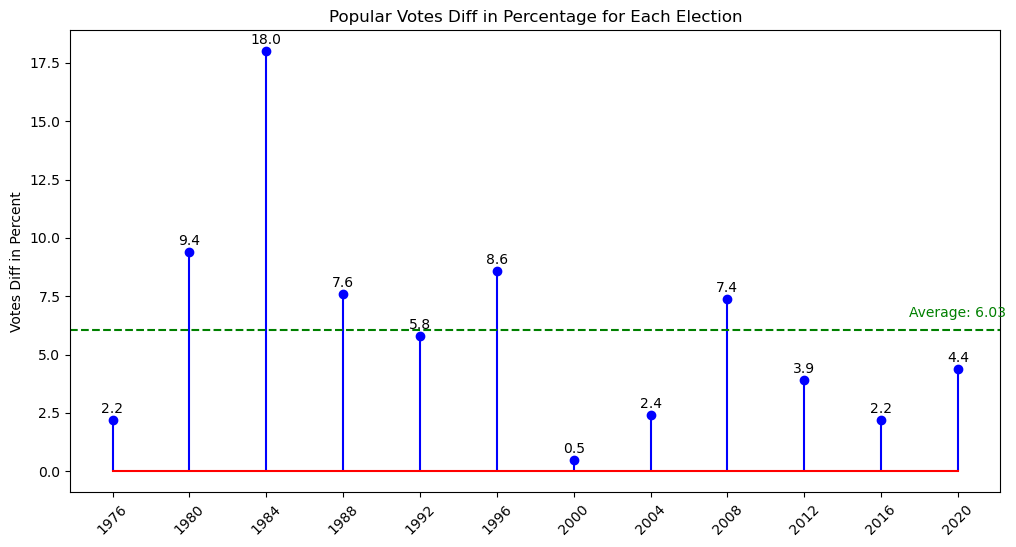

In [59]:
# Plotting the lollipop chart
plt.figure(figsize=(12, 6))

# Plotting the stems
plt.stem(df_national['Year'], df_national['Rep_Dem_national_abs'], linefmt='b-', markerfmt='bo', basefmt='r-')

# Calculate the average of 'df_national.Rep_Dem_national_abs'
avg_percent_diff = df_national.Rep_Dem_national_abs.mean()

# Adding data labels above each stem
for i, value in enumerate(df_national['Rep_Dem_national_abs']):
    plt.annotate(str(value), (df_national['Year'][i], value), textcoords="offset points", xytext=(0, 5), ha='center')

# Adding a line for the average value
plt.axhline(y=avg_percent_diff, color='g', linestyle='--', label='Average Value')

# Adding a data label for the average value
plt.annotate(f'Average: {avg_percent_diff:.2f}', xy=(df_national['Year'].iloc[-1], avg_percent_diff), xytext=(0, 10),
             textcoords='offset points', ha='center', color='g')


# Adding labels and title
#plt.xlabel('Year')
plt.ylabel('Votes Diff in Percent')
plt.title('Popular Votes Diff in Percentage for Each Election')

# Rotating x-axis labels for better readability (optional)
plt.xticks(df_national['Year'], rotation=45)

# Removing grid lines
plt.grid(False)

plt.savefig('Popular_vote_diff_lollipop.png', bbox_inches='tight')

# Display the plot
plt.show()



In [60]:
df_national['Year'].iloc[-1]

2020

In [61]:
#Plotting the differences 
my_range=range(1,len(df_national.index)+1)
my_range

range(1, 13)

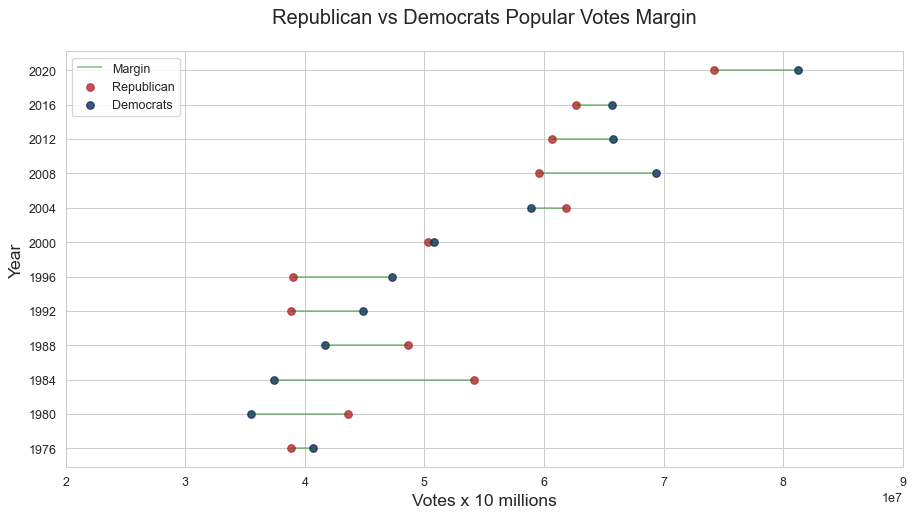

In [91]:
#Plotting the margin of popular votes
import seaborn as sns
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 6), dpi=90, facecolor='w', edgecolor='k')
sns.set_style('whitegrid')

plt.hlines(y = my_range, xmin = df_national['Rep_votes'], 
           xmax =df_national['Dem_votes'], color = 'green', alpha = 0.4)
plt.scatter(df_national['Rep_votes'], my_range, color = '#b4282e', alpha = 0.8)
plt.scatter(df_national['Dem_votes'], my_range, color = '#0b2d55', alpha = 0.8)
plt.legend(['Margin','Republican','Democrats'])
plt.yticks(np.arange(1, 13, step=1), 
           labels = (df_national['Year']))
plt.ylabel('Year', size = 14)
plt.xlim(20000000,90000000)
plt.xlabel('Votes x 10 millions', size = 14)
plt.title('Republican vs Democrats Popular Votes Margin', size = 16, y = 1.05)
plt.savefig('Popular_vote_margin.jpg')

Below section is dedicated to creating the animation that shows Electoral map from 1976 to 2020.

In [63]:
# create data frame that only contains winner from each election per state
df_winner = df_state.loc[df_state['rank_'] == 1.0]
df_winner = df_winner.rename(columns = {'state_po': 'STATE_ABBR',
                                        'party_simplified': 'Party-elected'})
df_winner

,year,state,STATE_ABBR,Party-elected,candidatevotes,totalvotes,rank_,unique_id
0,1976,ALABAMA,AL,DEMOCRAT,659170,1182850.0,1.0,1976AL
7,1976,ALASKA,AK,REPUBLICAN,71555,123574.0,1.0,1976AK
11,1976,ARIZONA,AZ,REPUBLICAN,418642,742719.0,1.0,1976AZ
12,1976,ARKANSAS,AR,DEMOCRAT,498604,767535.0,1.0,1976AR
17,1976,CALIFORNIA,CA,REPUBLICAN,3882244,7803770.0,1.0,1976CA
...,...,...,...,...,...,...,...,...
2335,2020,VIRGINIA,VA,DEMOCRAT,2413568,4460524.0,1.0,2020VA
2339,2020,WASHINGTON,WA,DEMOCRAT,2369612,4087631.0,1.0,2020WA
2346,2020,WEST VIRGINIA,WV,REPUBLICAN,545382,794652.0,1.0,2020WV
2347,2020,WISCONSIN,WI,DEMOCRAT,1630866,3298041.0,1.0,2020WI


In [64]:
#create a subset of winner data frame for multi-year visualization
df_winner_visual_muti = df_winner.loc[:, ['year','STATE_ABBR','Party-elected']]
df_winner_visual_muti

,year,STATE_ABBR,Party-elected
0,1976,AL,DEMOCRAT
7,1976,AK,REPUBLICAN
11,1976,AZ,REPUBLICAN
12,1976,AR,DEMOCRAT
17,1976,CA,REPUBLICAN
...,...,...,...
2335,2020,VA,DEMOCRAT
2339,2020,WA,DEMOCRAT
2346,2020,WV,REPUBLICAN
2347,2020,WI,DEMOCRAT


In [447]:
# plotting multi year election results by state
fig = px.choropleth(
    df_winner_visual_muti, 
    locations="STATE_ABBR",  
    locationmode="USA-states",  
    animation_frame="year",  
    color="Party-elected",  
    color_discrete_map={"REPUBLICAN": "#b4282e", 
                        "DEMOCRAT": "#0b2d55"},
    #title="Electoral College Maps from 1976 to 2020",
    scope="usa", 
)

fig = fig.add_scattergeo(
    locations=df_winner_visual_muti['STATE_ABBR'],
    locationmode="USA-states", 
    text=df_winner_visual_muti['STATE_ABBR'],
    textposition='top center',
    mode='text',name='State',
    textfont=dict(color='#f3f3f3',size=8))

# Set showlegend to False to hide the legend
fig.update_layout(showlegend=False)

In [448]:
fig.show()

# Export the animation as an HTML file
#pio.write_html(fig, file='1976_2020_Electoral_Map.html')

Features are calculated in the section below:
- Number of times each state flipped in the past six elections
- Number of Electoral votes each state has
- Number of Electoral votes per million of citizen population

In [67]:
# calculate how many times State changed preference during the election

df_flip_wip = df_winner.sort_values(by=['STATE_ABBR','year'], ascending=True).copy()

# Create a new column with the previous row's values
df_flip_wip['Previous_party_simplified'] = df_flip_wip['Party-elected'].shift(1)

# Check if the value in row n is the same as row n-1
df_flip_wip['flipped_from_prior'] = df_flip_wip['Party-elected'] != df_flip_wip['Previous_party_simplified']

# drop year 1976 since it does not have a prior year record
df_flip = df_flip_wip.loc[df_flip_wip['year'] > 1996]

# calculate how many times each state flipped
df_flip_group = df_flip.groupby(['STATE_ABBR','state']).agg({'flipped_from_prior':'sum'})

df_flip_group = df_flip_group.reset_index(drop=False)


In [68]:
# load csv that has electoral college data
df_electoral = pd.read_csv('data/Electoral_College.csv')

In [450]:
# merge df_flip_group with df_electoral
df_flip_electoral = pd.merge(df_flip_group, df_electoral,
                            left_on='STATE_ABBR',
                            right_on='Abb_State',
                             how='left')

In [451]:
df_flip_electoral

,STATE_ABBR,state,flipped_from_prior,Full_State,Abb_State,Electoral_College_Votes
0,AK,ALASKA,0,Alaska,AK,3
1,AL,ALABAMA,0,Alabama,AL,9
2,AR,ARKANSAS,1,Arkansas,AR,6
3,AZ,ARIZONA,2,Arizona,AZ,11
4,CA,CALIFORNIA,0,California,CA,55
5,CO,COLORADO,1,Colorado,CO,9
6,CT,CONNECTICUT,0,Connecticut,CT,7
7,DC,DISTRICT OF COLUMBIA,0,District of Columbia,DC,3
8,DE,DELAWARE,0,Delaware,DE,3
9,FL,FLORIDA,3,Florida,FL,29


In [452]:
df_citizen_pop = pd.read_csv('data/Total_citizen_pop_state.csv',
                             skiprows=range(4),
                             nrows=574,
                             usecols=[0,3])

df_citizen_pop = df_citizen_pop.loc[(df_citizen_pop['Characteristics'].isnull() != 1)
                                   & (df_citizen_pop['Characteristics'] != 'UNITED STATES')]

In [453]:
df_citizen_pop

,Characteristics,Total citizen population
12,ALABAMA,3716.0
23,ALASKA,516.0
34,ARIZONA,5093.0
45,ARKANSAS,2188.0
56,CALIFORNIA,25315.0
67,COLORADO,4384.0
78,CONNECTICUT,2527.0
89,DELAWARE,754.0
100,DISTRICT OF COLUMBIA,476.0
111,FLORIDA,15449.0


In [465]:
df_flip_electoral_pop = pd.merge(df_flip_electoral, df_citizen_pop,
                            left_on='state',
                            right_on='Characteristics',
                             how='left')

In [466]:
df_flip_electoral_pop

,STATE_ABBR,state,flipped_from_prior,Full_State,Abb_State,Electoral_College_Votes,Characteristics,Total citizen population
0,AK,ALASKA,0,Alaska,AK,3,ALASKA,516.0
1,AL,ALABAMA,0,Alabama,AL,9,ALABAMA,3716.0
2,AR,ARKANSAS,1,Arkansas,AR,6,ARKANSAS,2188.0
3,AZ,ARIZONA,2,Arizona,AZ,11,ARIZONA,5093.0
4,CA,CALIFORNIA,0,California,CA,55,CALIFORNIA,25315.0
5,CO,COLORADO,1,Colorado,CO,9,COLORADO,4384.0
6,CT,CONNECTICUT,0,Connecticut,CT,7,CONNECTICUT,2527.0
7,DC,DISTRICT OF COLUMBIA,0,District of Columbia,DC,3,DISTRICT OF COLUMBIA,476.0
8,DE,DELAWARE,0,Delaware,DE,3,DELAWARE,754.0
9,FL,FLORIDA,3,Florida,FL,29,FLORIDA,15449.0


In [467]:
df_flip_electoral_pop.drop(['STATE_ABBR','state', 'Characteristics'],
                           axis = 'columns',inplace = True)

In [468]:
# Making 'Total citizen population' variable in millions, instead of thousands
df_flip_electoral_pop['citizen_pop_mil'] = df_flip_electoral_pop['Total citizen population'] / 1000
df_flip_electoral_pop['elec_per_pop'] = round((df_flip_electoral_pop['Electoral_College_Votes'] / df_flip_electoral_pop['citizen_pop_mil']),2)
df_flip_electoral_pop.rename(columns={'Full_State': 'State'}, inplace=True)
df_flip_electoral_pop

,flipped_from_prior,State,Abb_State,Electoral_College_Votes,Total citizen population,citizen_pop_mil,elec_per_pop
0,0,Alaska,AK,3,516.0,0.516,5.81
1,0,Alabama,AL,9,3716.0,3.716,2.42
2,1,Arkansas,AR,6,2188.0,2.188,2.74
3,2,Arizona,AZ,11,5093.0,5.093,2.16
4,0,California,CA,55,25315.0,25.315,2.17
5,1,Colorado,CO,9,4384.0,4.384,2.05
6,0,Connecticut,CT,7,2527.0,2.527,2.77
7,0,District of Columbia,DC,3,476.0,0.476,6.30
8,0,Delaware,DE,3,754.0,0.754,3.98
9,3,Florida,FL,29,15449.0,15.449,1.88


In [469]:
# load and transpose the gdp by state csv file
df_gdp = pd.read_csv('data/gross domestic product (gdp) by state (dollars).csv',nrows=1).T

In [470]:
# calculate the log for 2022_GDP column and filter the data
df_gdp.reset_index(drop=False, inplace=True)
df_gdp.columns = ['State','2022_GDP']
df_gdp['2022_GDP_log'] = np.log(df_gdp['2022_GDP'])
df_gdp = df_gdp.loc[df_gdp['State'] != 'Years']

In [471]:
# merge df_gdp with df_flip_electoral_pop for visualization
df_flip_electoral_pop_gdp = pd.merge(df_flip_electoral_pop, df_gdp,on='State',how='left')

In [472]:
df_flip_electoral_pop_gdp['2022_GDP_perCapita'] = (df_flip_electoral_pop_gdp['2022_GDP'] / 1000000) / df_flip_electoral_pop_gdp['Total citizen population']
df_flip_electoral_pop_gdp['2022_GDP_mil'] = df_flip_electoral_pop_gdp['2022_GDP'] / 1000000
df_flip_electoral_pop_gdp['2022_GDP_mil_log'] = np.log(df_flip_electoral_pop_gdp['2022_GDP_mil'])
df_flip_electoral_pop_gdp['2022_GDP_perCapita_log'] = np.log(df_flip_electoral_pop_gdp['2022_GDP_perCapita'])

In [473]:
df_flip_electoral_pop_gdp

,flipped_from_prior,State,Abb_State,Electoral_College_Votes,Total citizen population,citizen_pop_mil,elec_per_pop,2022_GDP,2022_GDP_log,2022_GDP_perCapita,2022_GDP_mil,2022_GDP_mil_log,2022_GDP_perCapita_log
0,0,Alaska,AK,3,516.0,0.516,5.81,6.361800e+10,24.876162,123.290698,63618.0,11.060652,4.814545
1,0,Alabama,AL,9,3716.0,3.716,2.42,2.778175e+11,26.350230,74.762513,277817.5,12.534720,4.314317
2,1,Arkansas,AR,6,2188.0,2.188,2.74,1.652206e+11,25.830547,75.512157,165220.6,12.015037,4.324294
3,2,Arizona,AZ,11,5093.0,5.093,2.16,4.589498e+11,26.852207,90.113843,458949.8,13.036696,4.501074
4,0,California,CA,55,25315.0,25.315,2.17,3.598103e+12,28.911428,142.133229,3598102.7,15.095917,4.956765
5,1,Colorado,CO,9,4384.0,4.384,2.05,4.843715e+11,26.906118,110.486200,484371.5,13.090607,4.704891
6,0,Connecticut,CT,7,2527.0,2.527,2.77,3.218446e+11,26.497335,127.362327,321844.6,12.681824,4.847036
7,0,District of Columbia,DC,3,476.0,0.476,6.30,1.623144e+11,25.812801,340.996639,162314.4,11.997290,5.831873
8,0,Delaware,DE,3,754.0,0.754,3.98,8.752480e+10,25.195188,116.080637,87524.8,11.379677,4.754285
9,3,Florida,FL,29,15449.0,15.449,1.88,1.389070e+12,27.959655,89.913244,1389069.7,14.144145,4.498845


In [474]:
# Create horizontal bar chart
fig = px.bar(df_flip_electoral_pop_gdp.sort_values(by='Electoral_College_Votes', ascending=True),
             x='Electoral_College_Votes', y='State', orientation='h',
             text='Electoral_College_Votes')
             #title='Number of Electoral votes in Each State')

# Set the height of the plot to accommodate all y-axis labels
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False, showline=False, zeroline=False),
                  xaxis_title=None,
                  yaxis_title=None,
                  title=dict(text='Number of Electoral votes in Each State',x = 0.5),
                  height=1000)

# Set the angle of rotation for data labels on the x-axis
fig.update_traces(textangle=0,
                 textposition='outside')

# Show the plot
fig.show()

#fig.write_image("elec_bar.png")

In [475]:
# Create horizontal bar chart
fig = px.bar(df_flip_electoral_pop_gdp.sort_values(by='elec_per_pop', ascending=True),
             x='elec_per_pop', y='State', orientation='h',
             text='elec_per_pop')
             #title='Number of Electoral votes in Each State')

# Set the height of the plot to accommodate all y-axis labels
fig.update_layout(xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False, showline=False, zeroline=False),
                  xaxis_title=None,
                  yaxis_title=None,
                  title=dict(text='Number of Electoral votes per million of citizen population',x = 0.5),
                  height=1000)

# Set the angle of rotation for data labels on the x-axis
fig.update_traces(textangle=0,
                 textposition='outside')

# Show the plot
fig.show()

#fig.write_image("elec_pop_bar.png")

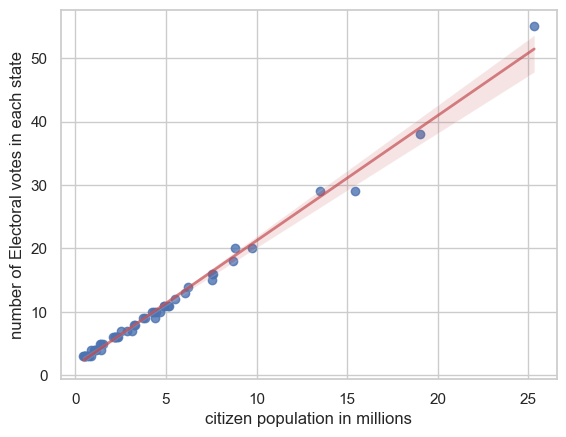

In [479]:
# Create scatterplot
sns.regplot(x=df_flip_electoral_pop_gdp["citizen_pop_mil"], y=df_flip_electoral_pop["Electoral_College_Votes"], line_kws={"color":"r","alpha":0.7,"lw":2})

# Rename the x-axis and y-axis labels
plt.xlabel('citizen population in millions')
plt.ylabel('number of Electoral votes in each state')


# Save plot
plt.savefig('pop_electoral_regression.png', format='png')

plt.show()

In [480]:
x=df_flip_electoral_pop_gdp["citizen_pop_mil"]
y=df_flip_electoral_pop["Electoral_College_Votes"]


# Calculate Pearson correlation coefficient
corr_coefficient, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.9961636766825782
P-value: 1.6480032824779172e-53


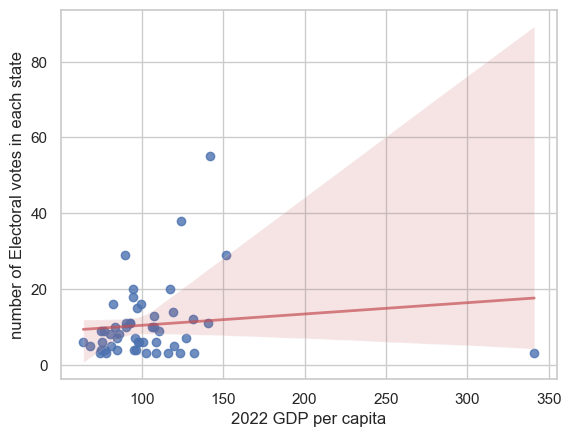

In [481]:
# Create scatterplot
sns.regplot(x=df_flip_electoral_pop_gdp["2022_GDP_perCapita"], y=df_flip_electoral_pop_gdp["Electoral_College_Votes"], line_kws={"color":"r","alpha":0.7,"lw":2})

# Rename the x-axis and y-axis labels
plt.xlabel('2022 GDP per capita')
plt.ylabel('number of Electoral votes in each state')


# Save plot
plt.savefig('gdp_electoral_regression.png', format='png')

plt.show()

In [483]:
x=df_flip_electoral_pop_gdp["2022_GDP_perCapita"]
y=df_flip_electoral_pop_gdp["Electoral_College_Votes"]


# Calculate Pearson correlation coefficient
corr_coefficient, p_value = pearsonr(x, y)

print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.12161348688731106
P-value: 0.39525569367386776


In [484]:
# plot the bubble chart
fig = px.scatter(df_flip_electoral_pop_gdp,#.query("elec_per_pop >= 3"),
                 x="2022_GDP_perCapita_log",
                 y="elec_per_pop",
                 size="citizen_pop_mil",
                 color="State",
                 hover_name="State",
                 size_max=60)



# Override x-axis and y-axis labels
fig.update_layout(
    xaxis_title="log of 2022 GDP per capita",
    yaxis_title="Electoral votes per million of population"
)

fig.show()

# Export the bubble chart to a png file
#fig.write_image("bubble_chart.png")

In [485]:
# create bubble plot
fig = px.scatter(df_flip_electoral_pop_gdp,#.query("flipped_from_prior>3"),
                 x="Electoral_College_Votes",
                 y="flipped_from_prior",
                 size="citizen_pop_mil",
                 color="State",
                 hover_name="State",
                 text = 'Abb_State',#log_x=True,
                 size_max=60)


# Override x-axis and y-axis labels
fig.update_layout(
    xaxis_title="Electoral Votes per state",
    yaxis_title="number of times state flipped",
    yaxis=dict(
        tickmode='array',
        tickvals=df_flip_electoral_pop_gdp['flipped_from_prior'],
        ticktext=df_flip_electoral_pop_gdp['flipped_from_prior']
    )
)

fig.show()
#fig.write_image("data/bubble_chart_elec_flip_50States.png")

In [486]:
top10_flipped = df_flip_electoral_pop_gdp.sort_values(by='flipped_from_prior', ascending=False).head(10)
top10_electoral = df_flip_electoral_pop_gdp.sort_values(by='Electoral_College_Votes', ascending=False).head(10)
top10_electoral_pop = df_flip_electoral_pop_gdp.sort_values(by='elec_per_pop', ascending=False).head(10)

In [487]:
fig_bar_flipped = px.bar(top10_flipped,
                         x='State',
                         y='flipped_from_prior',
                         text='flipped_from_prior')
                    

# Update layout
fig_bar_flipped.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='number of times a state flipped',
                                title=dict(text='Top 10 swing states',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
#fig_bar_flipped.write_image('top10_swing_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility

fig_bar_flipped.show()

In [488]:
fig_bar_electoral = px.bar(top10_electoral,
                           x='State',
                           y='Electoral_College_Votes',
                           text='Electoral_College_Votes')


# Update layout
fig_bar_electoral.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='number of Electoral votes',
                                title=dict(text='Top 10 states and their number of Electoral votes',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
#fig_bar_electoral.write_image('electoral_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility


fig_bar_electoral.show()

In [489]:
fig_bar_electoral_pop = px.bar(top10_electoral_pop,
                           x='State',
                           y='elec_per_pop',
                           text='elec_per_pop')


# Update layout
fig_bar_electoral_pop.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                                xaxis=dict(showgrid=False),
                                yaxis=dict(showgrid=False, showline=False, zeroline=False),
                                xaxis_title=None,
                                yaxis_title='Electoral votes per MM citizen population',
                                title=dict(text='Top 10 states and their Electoral votes per MM citizen population',
                                           x = 0.5))

# Save the chart as an image file (e.g., PNG or PDF)
#fig_bar_electoral_pop.write_image('electoral_pop_bar_chart.png', engine='kaleido')  # Use 'kaleido' engine for better compatibility


fig_bar_electoral_pop.show()

In [490]:
# create map with state's electoral votes
fig = px.choropleth(
    df_flip_electoral_pop_gdp, 
    locations="Abb_State",  
    locationmode="USA-states",
    scope="usa",
    labels={'Electoral_College_Votes':'no. of Electoral votes'}
)


fig = fig.add_scattergeo(
    locations=df_flip_electoral_pop_gdp['Abb_State'],
    locationmode="USA-states", 
    text=df_flip_electoral_pop_gdp['Electoral_College_Votes'],
    textposition='middle center',
    mode='text',name='State',
    textfont=dict(color='#f3f3f3',size=10))

# Set showlegend to False to hide the legend
fig.update_layout(
    title=dict(
        text='Electoral Power measured by no. of Electoral votes',
        x= 0.4)#,showlegend=False)
)

fig.show()

#fig.write_image("data/elec_map.png")

In [491]:
# plotting power map measured by number of electoral votes
fig = px.choropleth(
    df_flip_electoral_pop_gdp, 
    locations="Abb_State",  
    locationmode="USA-states",
    color_continuous_scale='Purples',
    color="Electoral_College_Votes",  
    #title="Electoral votes map",
    scope="usa",
    #text=(['Abb_State','Electoral_College_Votes']),
    labels={'Electoral_College_Votes':'no. of Electoral votes'}
)


# Set showlegend to False to hide the legend
fig.update_layout(
    title=dict(
        #text='Electoral Power measured by no. of Electoral votes',
        x= 0.4)#,showlegend=False)
)

fig.show()

#fig.write_image("elec_map.png")

In [492]:
# plotting power map measured by number of electoral votes per MM of citizen population
fig = px.choropleth(
    df_flip_electoral_pop_gdp, 
    locations="Abb_State",  
    locationmode="USA-states",
    color_continuous_scale='Purples',
    color="elec_per_pop",  
    #title="Electoral Power measured by votes per mil of pop map",
    scope="usa",
    #text=(['Abb_State','Electoral_College_Votes']),
    labels={'elec_per_pop':'Electoral votes per mil of pop'}
)

# Set showlegend to False to hide the legend
fig.update_layout(
    title=dict(
        #text='Electoral Power measured by no. of Electoral votes per mil of pop',
        x= 0.4)#,showlegend=False)
)

    
fig.show()

#fig.write_image("elec_pop_map.png")